In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#from hmmlearn import hmm


In [6]:
def euclidean_distance(x1, x2, y1, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2)**2)

def simulting_func(input_size, start, stop):
    #simulate series with noises
    x_series =  np.linspace(start, stop, input_size) + np.random.rand(input_size)/100
    x_series = np.sort(x_series)
    y_series = np.sin(2 * np.pi * x_series) + np.random.rand(input_size)
    return [x_series,y_series]
    

In [7]:
# simulating FX series zith x axis mismatch in time
np.random.seed(42)
input_size = 100

x1_series,y1_series = simulting_func(input_size, 0, 2)
x2_series,y2_series = simulting_func(input_size, 0, 2)

x1_pd = pd.Series(x1_series, name="x1")
x2_pd = pd.Series(x2_series, name="x2")

y1_pd = pd.Series(y1_series, name="y1")
y2_pd = pd.Series(y2_series, name="x2")


pd1 = pd.DataFrame({'x': x1_series,'x1': x1_series, 'y1': y1_series})
pd2 = pd.DataFrame({'x': x2_series,'x2': x2_series, 'y2': y2_series})

#print(pd1.head(10))
#print(pd2.head(10))

pd_dtw = pd.merge(pd1, pd2, how="outer",on="x")
pd_dtw = pd_dtw.ffill()
pd_dtw = pd_dtw.bfill()

print(pd_dtw.head(10))

corr1 = np.corrcoef( pd_dtw["y1"], pd_dtw["y2"])
print(f'Correlation before DTW: {corr1[0, 1]:.4f}')


          x        x1        y1        x2        y2
0  0.003745  0.003745  0.054960  0.006420  0.092011
1  0.006420  0.003745  0.054960  0.006420  0.092011
2  0.021043  0.003745  0.054960  0.021043  0.663189
3  0.029709  0.029709  0.821996  0.021043  0.663189
4  0.042020  0.029709  0.821996  0.042020  0.801600
5  0.047724  0.047724  0.609741  0.042020  0.801600
6  0.066593  0.066593  0.914882  0.042020  0.801600
7  0.069592  0.066593  0.914882  0.069592  1.060886
8  0.082368  0.082368  1.402306  0.069592  1.060886
9  0.086872  0.082368  1.402306  0.086872  1.245223
Correlation before DTW: 0.8573


In [67]:
def dtw_distance_constraint(x_ts1 ,y_ts1, x_ts2, y_ts2, slope):
    """
    Compute the Dynamic Time Warping distance between two time series.

        Parameters:
    - ts1 x,y (array-like): First time series.
    - ts2 x,y (array-like): Second time series.
    - slope (float): Slope parameter for the Itakura Parallelogram restriction.

    Léa Note other package : from tslearn.metrics import dtw_path

    """
    n, m = len(y_ts1), len(y_ts2)
    dtw_ix = np.zeros((n , m ))

    for i in range(n ):
        dtw_ix[i, 0] = np.inf
    for j in range(m ):
        dtw_ix[0, j] = np.inf
    dtw_ix[0, 0] = euclidean_distance(x_ts1[0],y_ts1[0],x_ts2[0], y_ts2[0])

    for i in range(1, n):
        for j in range(max(1, int(m / n * (i-1) - slope * (i-1))), min(m, int(m / n * i + i / slope ) + 1)):
            #Itakura Parallelogram constraint
            if (slope * (j - i)) < (m / n) < (1 / slope * (j - i)) :
            #Itakura Parallelogram constraint
                insertion = dtw_ix[i - 1, j]
                deletion = dtw_ix[i, j - 1]
                match = dtw_ix[i - 1, j - 1]
                min_path = min(insertion, deletion, match)
                dtw_ix[i, j] = euclidean_distance(x_ts1[i - 1],y_ts1[i-1],x_ts2[i - 1], y_ts2[j - 1]) + min_path

    return [dtw_ix,dtw_ix[n-1, m-1]]

def dtw_distance_constraint_sakoe(x_ts1 ,y_ts1, x_ts2, y_ts2, window):
    """
    Compute the Dynamic Time Warping distance between two time series.

        Parameters:
    - ts1 x,y (array-like): First time series.
    - ts2 x,y (array-like): Second time series.
    - slope (float): Slope parameter for the Itakura Parallelogram restriction.

    Léa Note other package : from tslearn.metrics import dtw_path

    """
    n, m = len(y_ts1), len(y_ts2)
    dtw_ix = np.zeros((n , m ))

    for i in range(n ):
        dtw_ix[i, 0] = np.inf
    for j in range(m ):
        dtw_ix[0, j] = np.inf
    dtw_ix[0, 0] = euclidean_distance(x_ts1[0],y_ts1[0],x_ts2[0], y_ts2[0])

    for i in range(1,n):
        for j in range(max(1, i - window), min(m , i + window )):
            insertion = dtw_ix[i - 1, j]
            deletion = dtw_ix[i, j - 1]
            match = dtw_ix[i - 1, j - 1]
            min_path = min(insertion, deletion, match)
            cost = euclidean_distance(x_ts1[i - 1],y_ts1[i-1],x_ts2[i - 1], y_ts2[j - 1])
            dtw_ix[i, j] = cost + min_path

    return [dtw_ix,dtw_ix[n-1, m-1]]

def dtw_distance(x_ts1 ,y_ts1, x_ts2, y_ts2, slope):
    """
    Compute the Dynamic Time Warping distance between two time series.

        Parameters:
    - ts1 x,y (array-like): First time series.
    - ts2 x,y (array-like): Second time series.
    - slope (float): Slope parameter for the Itakura Parallelogram restriction.

    Léa Note other package : from tslearn.metrics import dtw_path

    """
    n, m = len(y_ts1), len(y_ts2)
    dtw_ix = np.zeros((n , m ))

    for i in range(n ):
        dtw_ix[i, 0] = np.inf
    for j in range(m ):
        dtw_ix[0, j] = np.inf
    dtw_ix[0, 0] = euclidean_distance(x_ts1[0],y_ts1[0],x_ts2[0], y_ts2[0])

    for i in range(1, n):
        for j in  range(1, m):
            insertion = dtw_ix[i - 1, j]
            deletion = dtw_ix[i, j - 1]
            match = dtw_ix[i - 1, j - 1]
            min_path = min(insertion, deletion, match)
            cost = euclidean_distance(x_ts1[i - 1],y_ts1[i-1],x_ts2[i - 1], y_ts2[j - 1])
            dtw_ix[i, j] = cost + min_path
    return [dtw_ix,dtw_ix[n-1, m-1]]

distance = dtw_distance(x1_series, y1_series, x2_series, y2_series, 0.10)


In [9]:
print(distance[1])

146.71532718943428


In [10]:
def dtw_alignment_path(dtw_matrix):
    """
    Obtain the alignment path from the Dynamic Time Warping (DTW) matrix.

    Parameters:
    - dtw_matrix (ndarray): DTW matrix.

    Returns:
    - alignment_path (list): List of tuples representing the alignment path.
    """

    n, m = dtw_matrix.shape
    i, j = n - 1, m - 1
    alignment_path = [(i, j)]

    while i > 0 or j > 0:
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            # Determine the direction of movement based on the minimum neighbor
            min_neighbor = min(dtw_matrix[i - 1, j], dtw_matrix[i, j - 1], dtw_matrix[i - 1, j - 1])
            if min_neighbor == dtw_matrix[i - 1, j - 1]:
                i -= 1
                j -= 1
            elif min_neighbor == dtw_matrix[i - 1, j]:
                i -= 1
            else:
                j -= 1

        alignment_path.append((i, j))

    # Reverse the alignment path to obtain the correct order
    alignment_path.reverse()

    return alignment_path



In [11]:
print("Dynamic Time Warping distance:", distance[1])

new_wrapped = dtw_alignment_path(distance[0])

print("dist:", new_wrapped)


Dynamic Time Warping distance: 146.71532718943428
dist: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 42), (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 52), (53, 52), (54, 53), (55, 54), (56, 55), (57, 56), (58, 57), (59, 58), (60, 59), (61, 60), (62, 61), (63, 62), (64, 63), (65, 64), (66, 65), (67, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 86), (87, 87), (88, 88), (89, 89), (90, 90), (91, 91), (92, 92), (93, 93), (94

C:\Users\Léa\AppData\Local\Temp\ipykernel_11672\4113683985.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09201081910122459' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_y2[i] = y2_series[j]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


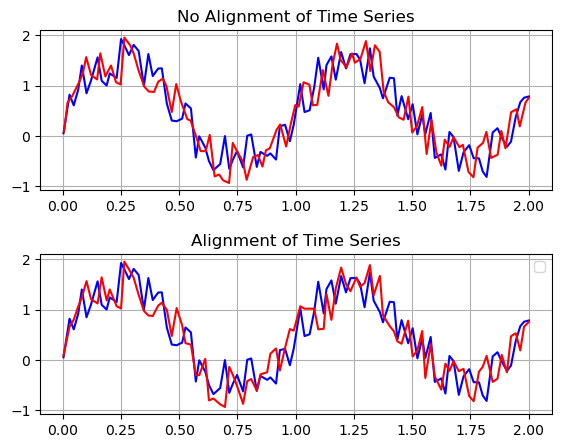

In [47]:

def plotting_dtw(x1_series,y1_series, x2_series,y2_series, alignement_path):
   new_y2 = pd.Series(range(input_size))
   for i, j in alignement_path:
      new_y2[i] = y2_series[j]


   fig, ax = plt.subplots(2, 1)
   ax[0].set_title('No Alignment of Time Series')
   ax[0].grid(True)

   ax[0].plot(x1_series, y1_series, label='Time Series 1', color='blue')
   ax[0].plot(x2_series, y2_series, label='Time Series 2', color='red')
   ax[1].plot(x1_series, y1_series, color='blue')
   ax[1].plot(x1_series, new_y2, color='red')

   ax[1].set_title('Alignment of Time Series')
   ax[1].grid(True)

   plt.legend()
   plt.subplots_adjust(left=0.1,
                     bottom=0.1, 
                     right=0.9, 
                     top=0.9, 
                     wspace=0.4, 
                     hspace=0.4)

   plt.show()

plotting_dtw(x1_series,y1_series, x2_series,y2_series, new_wrapped)


In [28]:
def plot_dtw(x1_series,y1_series, x2_series,y2_series, alignement_path, shift):
    plt.figure(figsize=(8, 4))
    plt.plot(x1_series,y1_series+shift, label='Time Series 1', color='blue')
    plt.plot(x2_series,y2_series, label='Time Series 2', color='red')

    for i, j in alignement_path:
        plt.plot([x1_series[i], x2_series[j]], [y1_series[i]+shift, y2_series[j]], color='green')

    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Alignment of Time Series')
    plt.legend()
    plt.grid(True)
    plt.show()

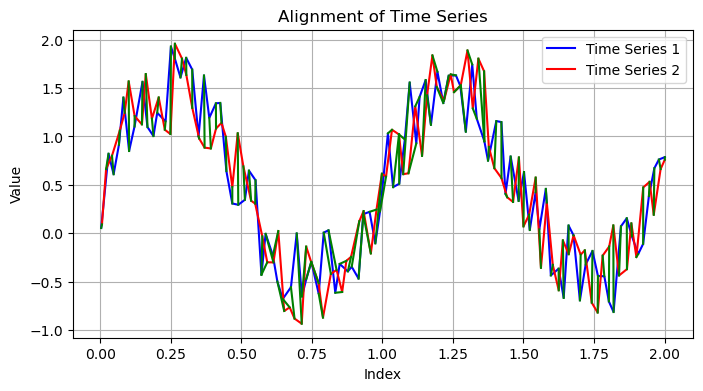

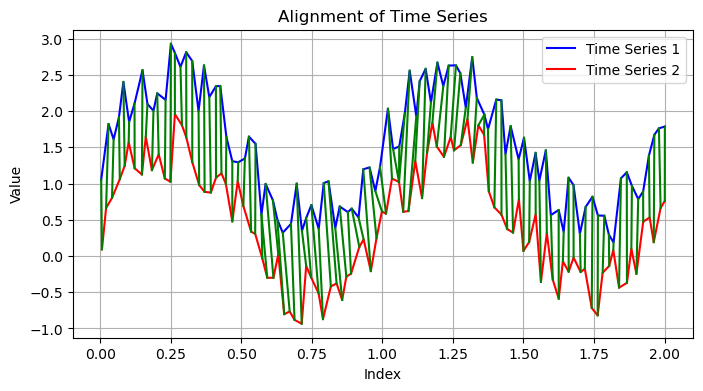

In [29]:
# we shift to better see the alignement
plot_dtw(x1_series,y1_series, x2_series,y2_series, new_wrapped, 0)
plot_dtw(x1_series,y1_series, x2_series,y2_series, new_wrapped, 1)


C:\Users\Léa\AppData\Local\Temp\ipykernel_11672\4113683985.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09201081910122459' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_y2[i] = y2_series[j]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[0.09974305        inf        inf ...        inf        inf        inf]
 [       inf 0.1994861  0.85824904 ... 0.         0.         0.        ]
 [       inf 0.99494536 1.2193246  ... 0.         0.         0.        ]
 ...
 [       inf 0.         0.         ... 4.5705993  2.34869464 0.        ]
 [       inf 0.         0.         ... 3.89756879 4.54058586 1.83168533]
 [       inf 0.         0.         ... 1.89668532 4.0659251  3.62984061]]


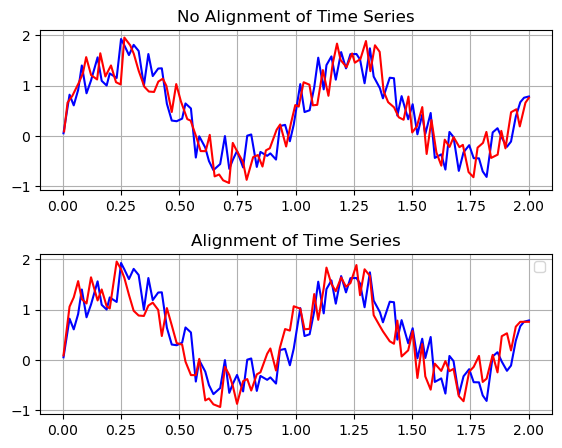

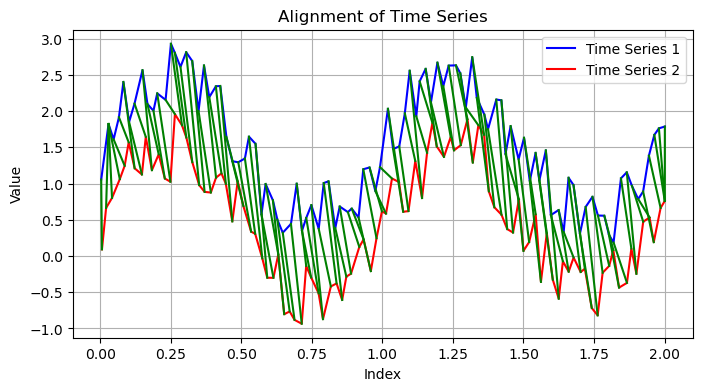

In [68]:
# using dtw with constraint 2
distance_constraint = dtw_distance_constraint_sakoe(x1_series, y1_series, x2_series, y2_series,2 )
toto = distance_constraint[0]
print(distance_constraint[0])
new_wrapped_constraint = dtw_alignment_path(distance_constraint[0])
plotting_dtw(x1_series, y1_series, x2_series, y2_series, new_wrapped_constraint)
plot_dtw(x1_series,y1_series, x2_series,y2_series,new_wrapped_constraint, 1)



C:\Users\Léa\AppData\Local\Temp\ipykernel_11672\4113683985.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.571178610227336' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_y2[i] = y2_series[j]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


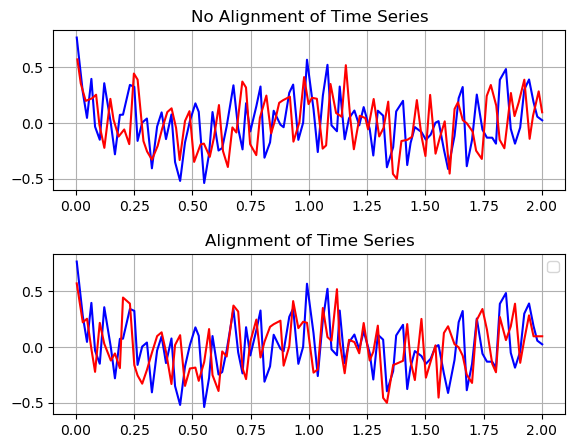

C:\Users\Léa\AppData\Local\Temp\ipykernel_11672\4113683985.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09201081910122459' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_y2[i] = y2_series[j]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


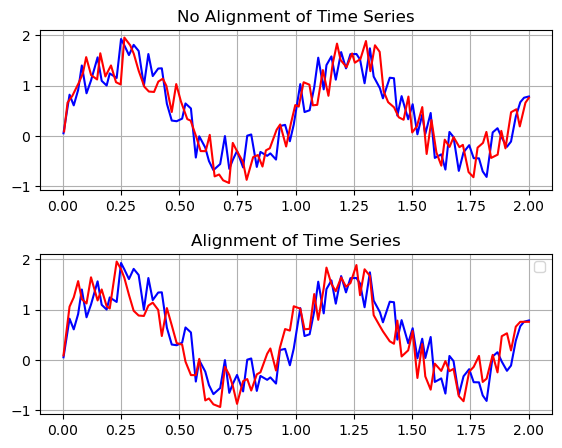

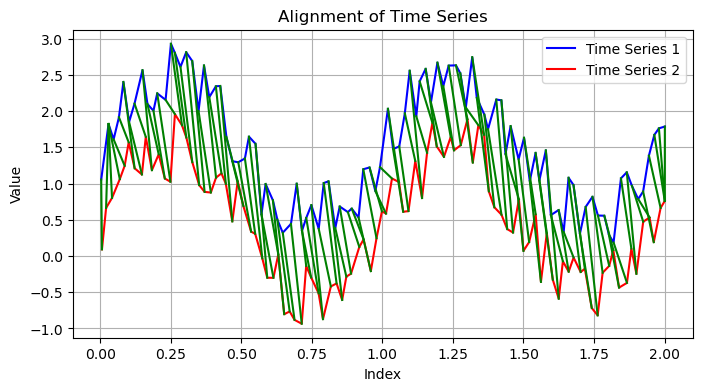

In [51]:

# Lets do the same with the derivative of the serie
# remark : it seems the gradient is not great for uneven x-1 or x+1 - it consider it is uniform 
y1_series_d = np.gradient(y1_series)
y2_series_d = np.gradient(y2_series)

distance_constraint_dev = dtw_distance_constraint_sakoe(x1_series, y1_series_d, x2_series, y2_series_d, 2)
new_wrapped_constraint = dtw_alignment_path(distance_constraint_dev[0])

plotting_dtw(x1_series,y1_series_d, x2_series,y2_series_d, new_wrapped_constraint)
plotting_dtw(x1_series,y1_series, x2_series,y2_series, new_wrapped_constraint)

# delete the noise and we have aligned the 2 series due to the simulation style
# but still in financial times series this is not expected 
plot_dtw(x1_series,y1_series, x2_series,y2_series,new_wrapped_constraint, 1)


In [ ]:
# increasing the size to start the prediction

input_size_rolling = 100

x1_series,y1_series = simulting_func(input_size_rolling, 2, 4)
x2_series,y2_series = simulting_func(input_size_rolling, 2, 4)

In [88]:
# I want a faster  DTW  - it probably possible to optimize the dtw calculation when adding a line 
def reduce(y_series):
    """Reduce the time series by averaging pairs of points."""
    return [(y_series[i] + y_series[i + 1]) / 2 for i in range(0, len(y_series) - 1, 2)]

def fastdtw(x1_series, x2_series, y1_series, y2_series, window, sakoe_const=2):
    """Compute the FastDTW distance between two time series by recurrence """
    if len(y1_series) < window or len(y2_series) < window:
        dtw = dtw_distance_constraint_sakoe(x1_series, y1_series, x2_series, y2_series, sakoe_const)
        return dtw_alignment_path(dtw[0])
    return fastdtw(reduce(x1_series), reduce(x2_series),reduce(y1_series), reduce(y2_series), window, sakoe_const)

# not convincing
fast_dtw = fastdtw(x1_series, y1_series, x2_series, y2_series, 51,2)
print(fast_dtw)


[(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 3), (7, 4), (8, 5), (9, 6), (10, 7), (11, 8), (12, 9), (13, 10), (14, 11), (15, 12), (16, 13), (17, 14), (18, 15), (19, 16), (20, 17), (21, 18), (22, 19), (23, 20), (24, 21), (25, 22), (26, 23), (27, 24), (28, 25), (29, 26), (30, 27), (31, 28), (32, 29), (33, 30), (34, 31), (35, 32), (36, 33), (37, 34), (38, 35), (39, 36), (40, 37), (41, 38), (42, 39), (43, 40), (44, 41), (45, 42), (46, 43), (47, 44), (48, 45), (48, 46), (48, 47), (48, 48), (49, 49)]


In [ ]:
class LiveHMM:

    def __init__(self, mmodel, params):
        self.mmodel =  mmodel
        self.params = params

    def predict(x1_series, x2_series, y1_series, y2_series):
        """
        Rolling DTW distance used for live 
        """
        holder = mmodel(x1_series, x2_series, y1_series, y2_series, max(len(idx), len(idx2)),params)

        return path_holder
    
    def training_rolling_time(x1_series, x2_series, y1_series, y2_series, window):
        """
        Compute the rolling DTW distance between two time series over a rolling time window.
        will be use for training - build the path holder to use for the learning model
        """
        current_time,j,i,n=0
        path_holder = []
        while current_time < (max(x1_series[-1],x2_series[-1])):
            # update current time
            current_time = min(x1_series[i],x2_series[j])
            idx = np.append(idx, np.where(x1_series <= current_time and x1_series >  current_time - window))
            idx2 = np.append(idx, np.where(x2_series <= current_time and x2_series > current_time-window))
            path_holder.append(self.mmodel(x1_series[idx], x2_series[idx2], y1_series[idx], y2_series[idx2], max(len(idx), len(idx2)),self.params))
            if current_time == x1_series[i] :
                i = i + 1
            if current_time == x2_series[j] :
                j = j + 1
        return path_holder

    def training_rolling_idx(x1_series, x2_series, y1_series, y2_series, window):
        """
        Compute the rolling DTW distance between two time series over a rolling time window.
        will be use for training - build the path holder to use for the learning model
        """
        current_time,j,i,n=0
        for i in range(len(ts1) - window_size + 1):
            self.mmodel(x1_series[i:i + window], x2_series[i:i + window], y1_series[i:i + window], y2_series[i:i + window], max(len(idx), len(idx2))/2,self.params)
  
        return path_holder



In [ ]:
#Gaussian HMM

#reminder of the markov chain : Xt+1 is only dependant of X at time t

#condition to use the model :
#continuous data/markov property : prob to mive to a state depends on the current state only/stationarity , the transition prob do not change over time.

    # Hidden Markov Model (HMM):
    # - HMM is a statistical model used to describe sequences of observable events, where the underlying system is assumed to be a Markov process with hidden states.
    # - It is commonly used in applications where the system being modeled is assumed to be a Markov process but where the states are not directly observable.
    # - HMMs consist of a set of states, transition probabilities between states, and emission probabilities for each state that determine the probability of observing a particular event given the current state.
    # Gaussian Mixture Model (GMM):
    # - GMM is a probabilistic model that assumes the data is generated from a mixture of several Gaussian distributions.
    # - It is commonly used for clustering, density estimation, and modeling complex data distributions.
    # - In a GMM, each component represents a Gaussian distribution with its own mean and covariance matrix.
    # - GMMs are flexible models that can approximate complex data distributions by combining multiple simpler distributions.


ghmm_model = hmm.GaussianHMM(n_components=5, covariance_type='diag', n_iter=100)
ghmm_model.fit(observations)
hidden_states = ghmm_model.predict(observations)

# After calibration, print the parameters
print("Transition matrix - prob to move from one state to another:\n", ghmm_model.transmat_)
# prediction observations 
print("Observations (first 10):", observations[:10].T[0])
print("Hidden States (first 10):", hidden_states[:10])


# using Sderivative for the DTW 
